## Binary Image Classification - Transfer Learning - v1.0 - Cat v/s Dog

### Author : Abhishek Dey "<ai.abhishekdey@gmail.com>"

### Import Libraries and Packages

In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense,  Dropout, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.models import load_model
from tensorflow.keras import applications

### Set GPU Flags

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Separate out dogs and cats in different folders

In [3]:
train_val_data_dir="dogs-vs-cats/train/"

train_val_dogs="dogs-vs-cats/train_val_images/dogs"
train_val_cats="dogs-vs-cats/train_val_images/cats"

if not os.path.exists(train_val_dogs):
    os.makedirs(train_val_dogs)
    
if not os.path.exists(train_val_cats):
    os.makedirs(train_val_cats)
    
source=train_val_data_dir
destination1=train_val_dogs
destination2=train_val_cats

for filename in os.listdir(source):
    if filename.startswith("dog"):
        shutil.copy(os.path.join(source, filename), destination1)
        
for filename in os.listdir(source):
    if filename.startswith("cat"):
        shutil.copy(os.path.join(source, filename), destination2)

### Get the counts of cats and dogs in train-val set

In [4]:
cat_count = 0
dog_count = 0 


for path in os.scandir(train_val_dogs):
    if path.is_file():
        dog_count += 1
print('train-val dogs count:', dog_count)

for path in os.scandir(train_val_cats):
    if path.is_file():
        cat_count += 1
print('train-val cats count:', cat_count)

train-val dogs count: 12500
train-val cats count: 12500


### Set Hyperparameters

In [5]:
ep=10
esp=3
bs=8
img_size=224
lr=0.00001
loss_fn='binary_crossentropy'

### Transerfer Learning from VGG16 Base Model

In [17]:
input_shape = (img_size, img_size, 3)

#base_model = applications.resnet50.ResNet50(weights="imagenet", include_top=False, input_shape= input_shape)
base_model = applications.VGG16(weights="imagenet", include_top=False, input_shape= input_shape)


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)

predictions = Dense(1, activation= 'sigmoid')(x)

model = Model(inputs = base_model.input, outputs = predictions)

In [18]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### Data Generation and train-val split in the ratio of 80:20

In [19]:
data_path = "dogs-vs-cats/train_val_images/"

data_gen = ImageDataGenerator(rescale=1./255,  validation_split=0.2)

train_data = data_gen.flow_from_directory(directory=data_path,target_size=(img_size,img_size), batch_size=bs, subset='training', seed=42, color_mode='rgb', class_mode='binary') 

val_data = data_gen.flow_from_directory(directory=data_path,target_size=(img_size,img_size), batch_size=bs, subset='validation', seed=42, color_mode='rgb', class_mode='binary') 

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


### Model Compile

In [20]:
opt = Adam(learning_rate=lr)

model.compile(loss=loss_fn,optimizer=opt,metrics=['accuracy'])

### Checkpoint directory

In [21]:
checkpoint_dir="VGG16_transfer_learning_model/"
model_version="1.0"

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

### Call backs

In [22]:
checkpoint = ModelCheckpoint(os.path.join(checkpoint_dir,'vgg16_tl_binary_model_v' + str(model_version) + '.h5'), 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')
csv_logger = CSVLogger(checkpoint_dir + '/' + 'log_model_v' + str(model_version) + '.csv')

early_stop = EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=esp,
        verbose=1,
        mode='auto')

### Model Fit

In [23]:
steps_train=train_data.n/ bs

steps_val = val_data.n / bs



history = model.fit(train_data, epochs=ep, steps_per_epoch=steps_train, validation_data=val_data, validation_steps=steps_val, callbacks= [checkpoint, csv_logger, early_stop])

Epoch 1/10
2500/2500 [==============================] - 934s 371ms/step - loss: 0.1449 - accuracy: 0.9361 - val_loss: 0.0632 - val_accuracy: 0.9760

Epoch 00001: val_loss improved from inf to 0.06323, saving model to VGG16_transfer_learning_model/vgg16_tl_binary_model_v1.0.h5
Epoch 2/10
2500/2500 [==============================] - 929s 372ms/step - loss: 0.0580 - accuracy: 0.9773 - val_loss: 0.0655 - val_accuracy: 0.9726

Epoch 00002: val_loss did not improve from 0.06323
Epoch 3/10
2500/2500 [==============================] - 916s 367ms/step - loss: 0.0379 - accuracy: 0.9855 - val_loss: 0.0535 - val_accuracy: 0.9816

Epoch 00003: val_loss improved from 0.06323 to 0.05348, saving model to VGG16_transfer_learning_model/vgg16_tl_binary_model_v1.0.h5
Epoch 4/10
2500/2500 [==============================] - 924s 370ms/step - loss: 0.0248 - accuracy: 0.9911 - val_loss: 0.0876 - val_accuracy: 0.9712

Epoch 00004: val_loss did not improve from 0.05348
Epoch 5/10
2500/2500 [====================

### Loss Plots

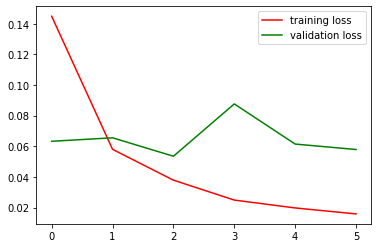

In [24]:
df_plot=pd.read_csv(os.path.join(checkpoint_dir, 'log_model_v' + str(model_version) + '.csv'))
training_loss=df_plot['loss']
validation_loss=df_plot['val_loss']
training_acc=df_plot['accuracy']
validation_acc=df_plot['val_accuracy']

plt.plot(training_loss,color='r')
plt.plot(validation_loss,color='g')
plt.legend(["training loss", "validation loss"], loc ="upper right")

## Accuracy Plots

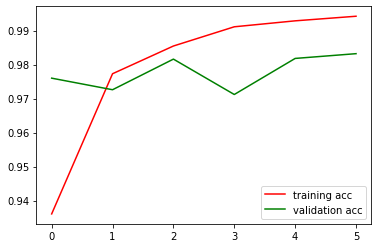

In [25]:
plt.plot(training_acc,color='r')
plt.plot(validation_acc,color='g')
plt.legend(["training acc", "validation acc"], loc ="lower right")

### Evaluation on Validation set

In [26]:
model_path = os.path.join(checkpoint_dir, 'vgg16_tl_binary_model_v' + str(model_version) + '.h5')
model = load_model(model_path)
_,val_accuracy = model.evaluate(val_data, steps=steps_val)

625/625 [==============================] - 61s 97ms/step - loss: 0.0535 - accuracy: 0.9816


### Prediction on Test set and strore the prediction results in csv file

In [27]:
test_set_dir="dogs-vs-cats/test1/"
out_csv = os.path.join(checkpoint_dir,"test_set_pred_" + str(model_version) + ".csv")

f=open(out_csv,'w')
f.write("filepath,prediction_label,prediction_class"+"\n")


for img in sorted(os.listdir(test_set_dir)):
    
    img_name = os.path.join(test_set_dir, img)
    
    img = load_img(img_name, target_size=(img_size, img_size))
    
    img = img_to_array(img)
    
    img = np.expand_dims(img, axis=0)
    
    pred = model.predict(img)
    
    if pred[0][0] > 0.5:
        
        result=1
        pred_class='dog'
        
    else:
        
        result=0
        pred_class='cat'
    
    #print(img_name,result,pred_class)
    f.write(str(img_name) + "," + str(result) + "," + str(pred_class) + "\n")

f.close()

### Convert Keras model to ONNX

In [28]:
!pip install tf2onnx

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [29]:
import tensorflow as tf
import tf2onnx
import onnx

In [30]:
keras_model_path=os.path.join(checkpoint_dir,'vgg16_tl_binary_model_v' + str(model_version) + '.h5')

In [31]:
keras_model_path

'VGG16_transfer_learning_model/vgg16_tl_binary_model_v1.0.h5'

In [32]:
onnx_model_path=os.path.join(checkpoint_dir,'vgg16_tl_binary_model_v' + str(model_version) + '.onnx')

In [33]:
onnx_model_path

'VGG16_transfer_learning_model/vgg16_tl_binary_model_v1.0.onnx'

In [34]:
keras_model = load_model(keras_model_path)
keras_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [35]:
spec = (tf.TensorSpec((None, 224, 224, 3), tf.float32, name="input"),)

onnx_model, _ = tf2onnx.convert.from_keras(keras_model, input_signature=spec, opset=13, output_path=onnx_model_path)

onnx.save(onnx_model, onnx_model_path)

### Inference using Onnx model on test set

In [36]:
! pip install onnxruntime-gpu

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [37]:
import onnxruntime as ort

sess = ort.InferenceSession(onnx_model_path, providers=["CUDAExecutionProvider"])

input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name

print("input_name : ",input_name)
print("output_name : ",input_name)

input_name :  input
output_name :  input


In [ ]:
test_set_dir="dogs-vs-cats/test1/"
out_csv = os.path.join(checkpoint_dir,"test_set_pred_onnx" + str(model_version) + ".csv")

f=open(out_csv,'w')
f.write("filepath,prediction_label,prediction_class"+"\n")

for img in sorted(os.listdir(test_set_dir)):
    
    img_name = os.path.join(test_set_dir, img)
    
    img = load_img(img_name, target_size=(img_size, img_size))
    
    img = img_to_array(img)
    
    img = np.expand_dims(img, axis=0)
    
    
    onnx_pred = sess.run([output_name], {input_name: img})
    
    if onnx_pred[0][0] > 0.5:
        
        result=1
        pred_class='dog'
        
    else:
        
        result=0
        pred_class='cat'
    
    #print(img_name,result,pred_class)
    f.write(str(img_name) + "," + str(result) + "," + str(pred_class) + "\n")

f.close()

### References:

* https://onnxruntime.ai/docs/tutorials/tf-get-started.html

* https://github.com/onnx/tensorflow-onnx/blob/82812543c22e1318ca1ffa4e5431830c17d16d29/tutorials/keras-resnet50.ipynb

* https://www.youtube.com/watch?v=lRBsmnBE9ZA

* https://github.com/onnx/tensorflow-onnx/blob/main/tutorials/efficientnet-edge.ipynb